# Assignment 2: Upper Confidence Bound
Tommy - Tongle Shen

In [1]:
import pandas as pd
import numpy as np 
import random
import matplotlib.pyplot as plt

### Data Preprocessing
Movie-1m dataset preprocessing code copied from hw1

In [2]:
ratings = pd.read_csv('../dataset/ml-1m/ratings.dat', sep='::', names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python', encoding='ISO-8859-1')
movies = pd.read_csv('../dataset/ml-1m/movies.dat', sep='::', names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')

data = pd.merge(ratings, movies, on='MovieID')

data['Genres'] = data['Genres'].str.split('|')
data = data.explode('Genres')

print(data.head())

   UserID  MovieID  Rating  Timestamp                                   Title  \
0       1     1193       5  978300760  One Flew Over the Cuckoo's Nest (1975)   
1       2     1193       5  978298413  One Flew Over the Cuckoo's Nest (1975)   
2      12     1193       4  978220179  One Flew Over the Cuckoo's Nest (1975)   
3      15     1193       4  978199279  One Flew Over the Cuckoo's Nest (1975)   
4      17     1193       5  978158471  One Flew Over the Cuckoo's Nest (1975)   

  Genres  
0  Drama  
1  Drama  
2  Drama  
3  Drama  
4  Drama  


In [3]:
arms_rewards_df = data.groupby('Genres')['Rating'].apply(list).reset_index()

print(arms_rewards_df.head())

       Genres                                             Rating
0      Action  [3, 5, 5, 5, 4, 5, 4, 3, 4, 5, 5, 5, 5, 4, 5, ...
1   Adventure  [3, 5, 5, 5, 4, 5, 4, 3, 4, 5, 5, 5, 5, 4, 5, ...
2   Animation  [3, 2, 3, 5, 4, 5, 3, 2, 5, 4, 3, 1, 4, 5, 3, ...
3  Children's  [3, 2, 3, 5, 4, 5, 3, 2, 5, 4, 3, 1, 4, 5, 3, ...
4      Comedy  [5, 5, 5, 4, 4, 1, 5, 4, 5, 5, 3, 3, 3, 3, 4, ...


### Problem 1

In [9]:
class UCB:
    def __init__(self, k, n, B=4):
        self.k = k
        self.n = n
        self.B = B  
        
        self.arm_means = np.zeros(k)
        self.arm_counts = np.zeros(k)
        self.cumulative_regret = np.zeros(n)
    
    def select_arm(self, t):
        ucb_values = np.zeros(self.k)
        for i in range(self.k):
            if self.arm_counts[i] == 0:
                return i  
            ucb_values[i] = self.arm_means[i] + self.B * np.sqrt(4 * np.log(self.n) / (2 * self.arm_counts[i]))
        return np.argmax(ucb_values)
    
    def update(self, arm, reward):
        self.arm_counts[arm] += 1
        self.arm_means[arm] += (reward - self.arm_means[arm]) / self.arm_counts[arm]
    
    def run(self, rewards, n):
        optimal_reward = 5  
        for t in range(n):
            arm = self.select_arm(t)
            reward = random.choice(rewards[arm])  
            self.update(arm, reward)
            regret = optimal_reward - reward
            self.cumulative_regret[t] = self.cumulative_regret[t - 1] + regret if t > 0 else regret


In [10]:
n = 100000
num_experiments = 10
all_cumulative_regrets = []

for _ in range(num_experiments):
    print(f"Running Experiment {_ + 1}")
    ucb = UCB(k=len(arms_rewards_df), n=n, B=4)
    ucb.run(arms_rewards_df['Rating'], n)
    all_cumulative_regrets.append(ucb.cumulative_regret)

Running Experiment 1
Running Experiment 2
Running Experiment 3
Running Experiment 4
Running Experiment 5
Running Experiment 6
Running Experiment 7
Running Experiment 8
Running Experiment 9
Running Experiment 10


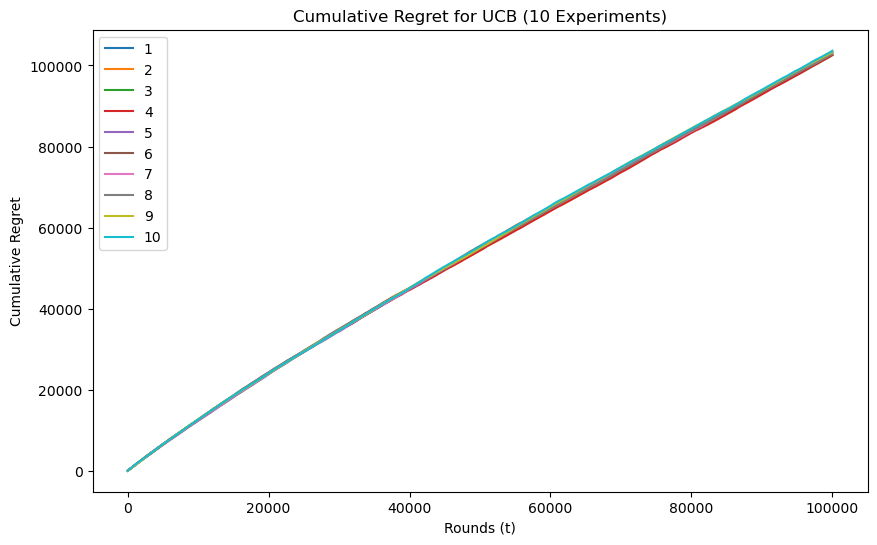

In [11]:
plt.figure(figsize=(10, 6))
for i in range(num_experiments):
    plt.plot(all_cumulative_regrets[i], label=f'{i+1}')
plt.xlabel('Rounds (t)')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret for UCB (10 Experiments)')
plt.legend()
plt.show()

Observations: \
Cumulative regrets are different for each experiment, and it seems to differ much more than ETC algorithm (in hw1) \
Moreover, since in UCB we do not have a exploration-commit phase change, all 10 curves seems to be smooth without any turning points

In [12]:
n = 100000
num_experiments = 100

all_cumulative_regrets = []
for _ in range(num_experiments):
    ucb = UCB(k=len(arms_rewards_df), n=n, B=4)
    ucb.run(arms_rewards_df['Rating'], n)
    all_cumulative_regrets.append(ucb.cumulative_regret)

all_cumulative_regrets = np.array(all_cumulative_regrets)

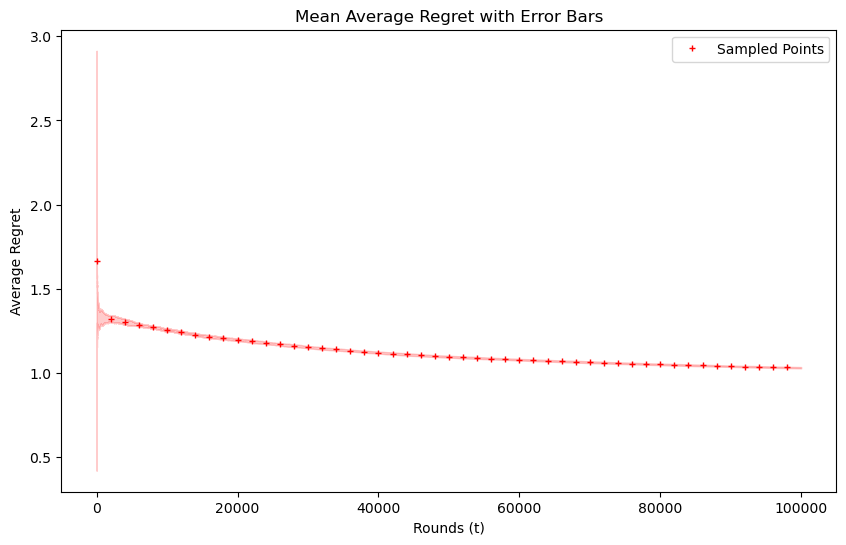

In [13]:
mean_cumulative_regret = np.mean(all_cumulative_regrets, axis=0)
std_cumulative_regret = np.std(all_cumulative_regrets, axis=0)

average_regret = mean_cumulative_regret / np.arange(1, n + 1)
std_average_regret = std_cumulative_regret / np.arange(1, n + 1)

sampling_interval = 2000
sampled_x = np.arange(0, n, sampling_interval)
sampled_average_regret = average_regret[::sampling_interval]

plt.figure(figsize=(10, 6))

plt.plot(sampled_x, sampled_average_regret, 'r+', markersize=5, label='Sampled Points')

plt.fill_between(range(n), average_regret - std_average_regret, average_regret + std_average_regret, color='red', alpha=0.2)

plt.xlabel('Rounds (t)')
plt.ylabel('Average Regret')
plt.title('Mean Average Regret with Error Bars')

plt.legend()
plt.show()

### Problem 2

In [14]:
def run_ucb_for_horizon(horizon, arms_rewards_df, num_experiments):
    all_cumulative_regrets = []
    for _ in range(num_experiments):
        ucb = UCB(k=len(arms_rewards_df), n=horizon, B=4)
        ucb.run(arms_rewards_df['Rating'], horizon)
        all_cumulative_regrets.append(ucb.cumulative_regret)
    
    all_cumulative_regrets = np.array(all_cumulative_regrets)
    mean_cumulative_regret = np.mean(all_cumulative_regrets, axis=0)
    
    average_regret = mean_cumulative_regret / np.arange(1, horizon + 1)
    
    return average_regret

In [15]:
horizons = [500, 5000, 50000, 500000, 5000000]
num_experiments = 100

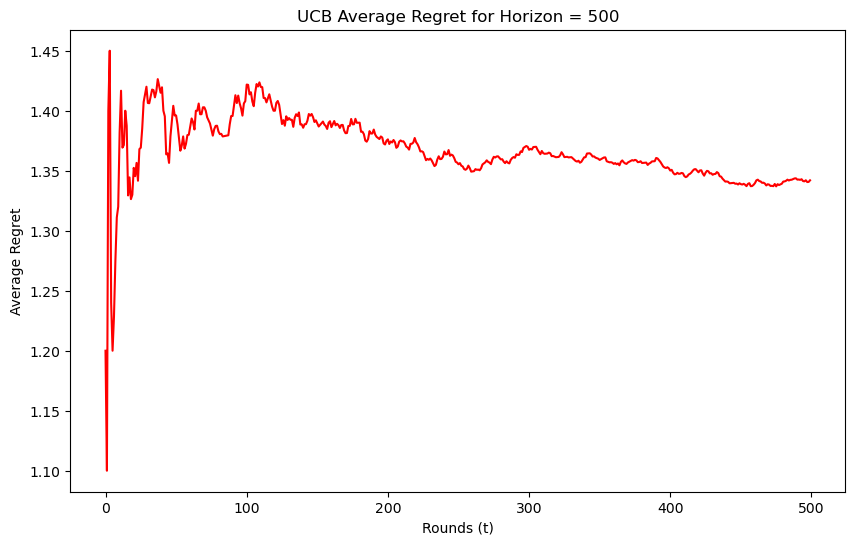

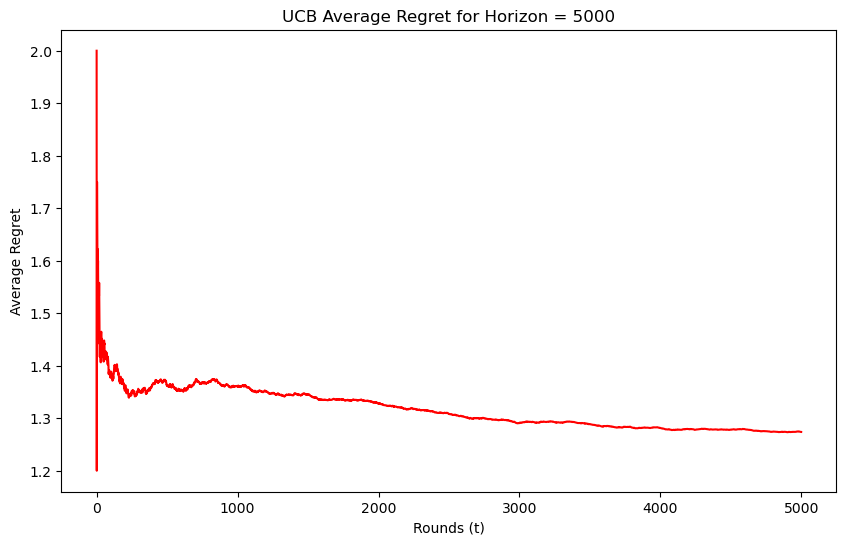

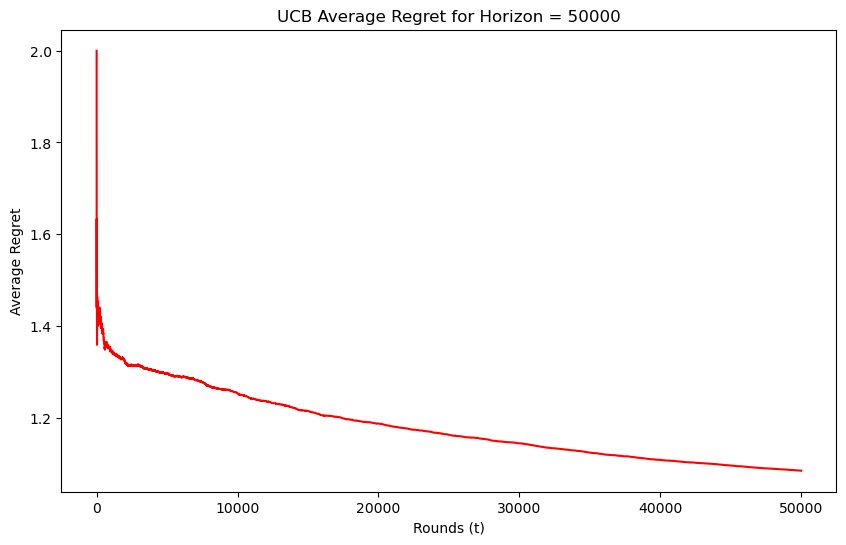

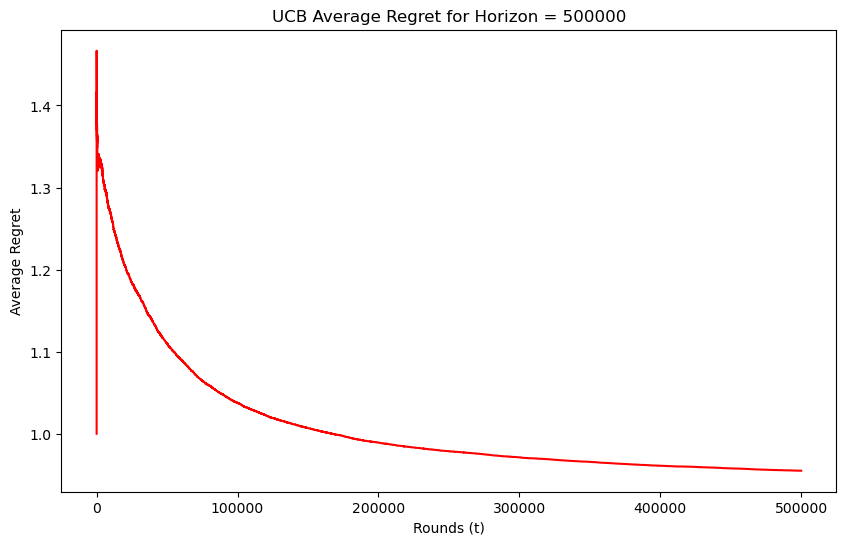

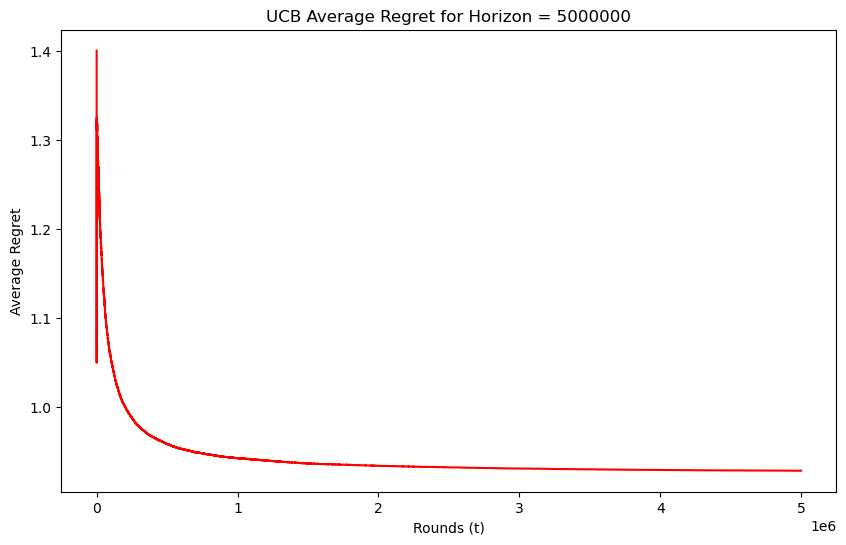

In [16]:
for horizon in horizons:
    avg_regret = run_ucb_for_horizon(horizon, arms_rewards_df, num_experiments)
    
    plt.figure(figsize=(10, 6))
    plt.plot(avg_regret, color='red')
    
    plt.xlabel('Rounds (t)')
    plt.ylabel('Average Regret')
    plt.title(f'UCB Average Regret for Horizon = {horizon}')
    
    plt.show()

Observation: \
The log curve does not appear until about 700 horizons

### Problem 3

In [17]:
# Define a new class for testing
class UCB:
    def __init__(self, k, n, B=4, l=1, is_aoucb=False):
        self.k = k
        self.n = n
        self.B = B
        self.l = l
        self.is_aoucb = is_aoucb
        
        self.arm_means = np.zeros(k)
        self.arm_counts = np.zeros(k)
        
        self.cumulative_regret = np.zeros(n)
    
    def select_arm(self, t):
        ucb_values = np.zeros(self.k)
        for i in range(self.k):
            if self.arm_counts[i] == 0:
                return i
            if self.is_aoucb:
                f_t = 1 + t * (np.log(t + 1))**2
                ucb_values[i] = self.arm_means[i] + self.B * np.sqrt(2 * np.log(f_t) / self.arm_counts[i])
            else:
                ucb_values[i] = self.arm_means[i] + self.B * np.sqrt(self.l * np.log(self.n) / self.arm_counts[i])
        return np.argmax(ucb_values)
    
    def update(self, arm, reward):
        self.arm_counts[arm] += 1
        self.arm_means[arm] += (reward - self.arm_means[arm]) / self.arm_counts[arm]
    
    def run(self, rewards, n):
        optimal_reward = 5
        for t in range(n):
            arm = self.select_arm(t)
            reward = random.choice(rewards[arm])
            self.update(arm, reward)
            regret = optimal_reward - reward
            self.cumulative_regret[t] = self.cumulative_regret[t - 1] + regret if t > 0 else regret

In [18]:
def run_experiments(arms_rewards_df, n, num_experiments, l=1, is_aoucb=False):
    cumulative_regrets = []
    for _ in range(num_experiments):
        ucb = UCB(k=len(arms_rewards_df), n=n, B=4, l=l, is_aoucb=is_aoucb)
        ucb.run(arms_rewards_df['Rating'], n)
        cumulative_regrets.append(ucb.cumulative_regret)
    return np.array(cumulative_regrets)

In [19]:
n = 100000
num_experiments = 100

all_cumulative_regrets = {
    "AOUCB": [],
    "UCB_l1": [],
    "UCB_l2": [],
    "UCB_l4": []
}

all_cumulative_regrets["AOUCB"] = run_experiments(arms_rewards_df, n, num_experiments, is_aoucb=True)
all_cumulative_regrets["UCB_l1"] = run_experiments(arms_rewards_df, n, num_experiments, l=1)
all_cumulative_regrets["UCB_l2"] = run_experiments(arms_rewards_df, n, num_experiments, l=2)
all_cumulative_regrets["UCB_l4"] = run_experiments(arms_rewards_df, n, num_experiments, l=4)

/var/folders/0n/36gg_gw54h5cjl8_grwsrp400000gn/T/ipykernel_10267/1734880928.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(sampled_x, sampled_mean_regret, 'r+', markersize=5, label=f'{label} Sampled Points', color=colors[idx])


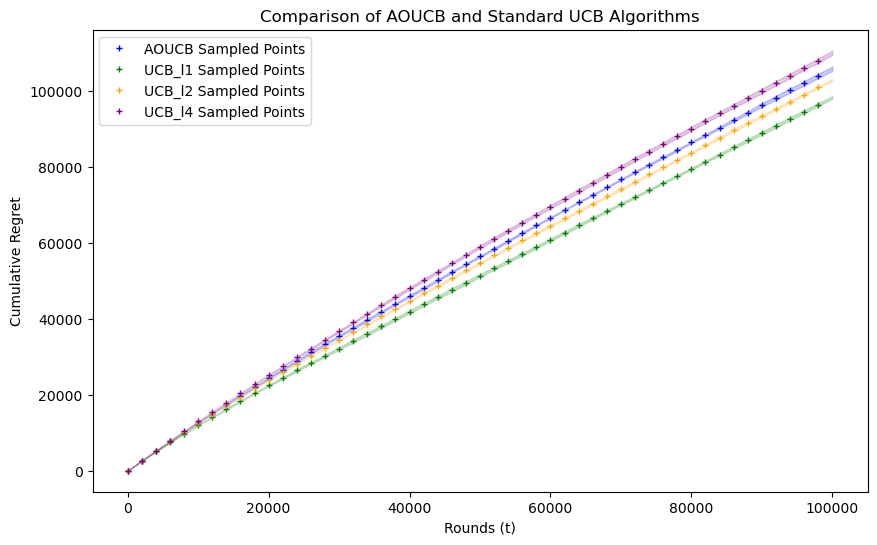

In [20]:
labels = ["AOUCB", "UCB_l1", "UCB_l2", "UCB_l4"]
colors = ["blue", "green", "orange", "purple"]

plt.figure(figsize=(10, 6))

for idx, label in enumerate(labels):
    mean_cumulative_regret = np.mean(all_cumulative_regrets[label], axis=0)
    std_cumulative_regret = np.std(all_cumulative_regrets[label], axis=0)
    
    sampling_interval = 2000
    sampled_x = np.arange(0, n, sampling_interval)
    sampled_mean_regret = mean_cumulative_regret[::sampling_interval]
    
    plt.plot(sampled_x, sampled_mean_regret, 'r+', markersize=5, label=f'{label} Sampled Points', color=colors[idx])
    
    plt.fill_between(range(n), mean_cumulative_regret - std_cumulative_regret, mean_cumulative_regret + std_cumulative_regret, color=colors[idx], alpha=0.2)

plt.xlabel('Rounds (t)')
plt.ylabel('Cumulative Regret')
plt.title('Comparison of AOUCB and Standard UCB Algorithms')

plt.legend()
plt.show()